# Stock Prediction Data

## Introduction
  * Supervised Learning Stock Prediction

## Load data

- use the getStockYF program to download stock data from Intrinio

In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
from io import StringIO
from IntrinioApiCredentials import *
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline

In [35]:
# Paramters

ticker = "^GSPC"  #  ^GSPC  Yahoo S&P ... SPX Intrinio S&P ... AAPL ...  
source='file' # ... doesn't matter
dataStartDate=dt.datetime(1950,1,1)  # 1990-01-01 ^GSPC Yahoo ... 2007-01-01 Intrinio
today = dt.date.today()
startDate=str(dataStartDate.year)+'-'+str(dataStartDate.month)+'-'+str(dataStartDate.day)
endDate=str(today.year)+'-'+str(today.month)+'-'+str(today.day)
truth_method = 'mc' #  ndt or mc n-day trend net price change ... mc market cycle
ndtrend = 10
train_st = dataStartDate
test_st = dt.datetime(1950,1,1)
test_et = dt.datetime(today.year,today.month,today.day)
initMarket=1 # market cycle ...
             # S&P =.... -1 1%, 2010-1-1  .... = 1 1%, 2014,1,1 ...
             # = 1, 20% .. 1%, 1950
             # = -1, 1%, 1990-1-1
             # = 1  1% and 5%, 2010-1-1
             # AAPL = +1 2007-1-1
       

In [12]:
# Get Data
%run algosciquant.py

print('ticker = ',ticker)

if source == 'Intrinio':
    from IntrinioApiCredentials import *
    if ticker !='SPX':
        sitems=['adj_close_price','adj_volume','pricetoearnings','ebitdagrowth','earningsyield','quickratio','pricetobook','evtoebitda','evtorevenue']
        dfs=getIntrinioStockData(ticker,startDate,endDate,api_username,api_password,items=sitems,v=0) # stock
        print(dfs.tail(5))
    dfsp=getIntrinisoSPData(startDate,endDate,api_username,api_password,v=0) # S&P
    print(dfsp.tail(5))
    
elif source == 'Yahoo':
    items=['adj_close_price','adj_volume']
    if ticker != '^GSPC':
        dfs=getYahooStockData(ticker,startDate,endDate,v=0) # stock data
        print(dfs.tail(5))
    dfsp=getYahooSPData(startDate,endDate,v=0) # S&P
    print(dfsp.tail(5))
    
elif source == 'file':
    if ticker == '^GSPC':
        dfsp = pd.read_csv('sp500.csv',index_col=0,parse_dates=True)
        dfsp = dfsp[dataStartDate:]
        print(dfsp.head(5))
        print('...)')
        print(dfsp.tail(5))
    
    
    else:
        filename='stock_'+ticker+'.csv'
        dfs = pd.read_csv(filename,index_col=0,parse_dates=True)
        dfs = dfs[dataStartDate:]
        print(dfs.head(5))
        print('...)')
        print(dfs.tail(5))





ticker =  ^GSPC
            close_price  high_price  low_price  open_price   volume
1950-01-03        16.66       16.66      16.66       16.66  1260000
1950-01-04        16.85       16.85      16.85       16.85  1890000
1950-01-05        16.93       16.93      16.93       16.93  2550000
1950-01-06        16.98       16.98      16.98       16.98  2010000
1950-01-09        17.08       17.08      17.08       17.08  2520000
...)
            close_price   high_price    low_price   open_price      volume
2017-03-30  2368.060059  2370.419922  2358.580078  2361.310059  3158420000
2017-03-31  2362.719971  2370.350098  2362.600098  2364.820068  3354110000
2017-04-03  2358.840088  2365.870117  2344.729980  2362.340088  3416400000
2017-04-04  2360.159912  2360.530029  2350.719971  2354.760010  3206240000
2017-04-05  2354.230000  2378.360000  2350.520000  2366.590000  3206240000


In [136]:
# Manually add S&P data to dfsp
# https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC  ... table of data for download
# https://finance.yahoo.com/quote/%5Egspc?ltr=1    ... Chart 1 year

#Mar 23, 2017	2,345.97	2,358.92	2,342.13	2,342.45

d={'open_price':2345.97,'high_price':2358.92,'low_price':2342.13,'close_price':2342.45,'volume':3432950000}
dftmp=pd.DataFrame(d,index=[dt.datetime(2017,3,23)])
dfsp=pd.concat([dfsp, dftmp])
dfsp.tail(5)

,close_price,high_price,low_price,open_price,volume
2017-03-23,2345.959961,2358.919922,2342.129883,2345.969971,3260600000
2017-03-24,2343.979980,2356.219971,2335.739990,2350.419922,2975130000
2017-03-27,2341.590088,2344.899902,2322.250000,2329.110107,3240230000
2017-03-28,2361.190000,2363.780000,2337.630000,2339.790000,3240230000
2017-03-23,2342.450000,2358.920000,2342.130000,2345.970000,3432950000


In [39]:
# Market Cycles 
%run marketCycle

stmc=dataStartDate
etmc=dt.datetime(today.year,today.month,today.day)

#mcdp = 0.2
#mcup = 0.25

mcdp = 0.1
mcup = 0.1


#mcdp = 0.01
#mcup = 0.01

mudLogic=mudLogic1

if ticker == '^GSPC' or ticker == 'SPX':
    price_variable='close_price'
    df=dfsp.loc[stmc:etmc]
else:
    price_variable='adj_close_price'
    df=dfs.loc[stmc:etmc]

print('ticker =',ticker)
print('price_variable =',price_variable)
print('mcdp =',mcdp)
print('mcup =',mcup)

print(" ...")

# note ... for ML purposes the following parameters should be useful
#    1. basic S&P daily price return and volume rate
#    2  market cycle basic parameters  ... mucdown, mdcup, mcupm
#    3  others should also be useful ... mcnr, mdclp, muchp, dfhlm

# Bull Bear 1:  strict definition of Bull, Bear
#mcdp = 0.2
#mcup =0.21

# Bull Bear 2:  conservative definition, eliminates short fake bulls 
#    as seen in 2001-2002 and 2008-2009 ... 
#    confuse machine learning because they are really part of a larger falling trend
#


(dfmc, dfmcsummary)=marketCycle(df,initMarket ,price_variable,mcdp,mcup,mudLogic)

print(dfmc.tail(10))
dfmcsummary[['mkt','startTime','endTime','startPrice','endPrice','mcnr']]

ticker = ^GSPC
price_variable = close_price
mcdp = 0.1
mcup = 0.1
 ...
            close_price  mkt  mchlm  newmhlm  sdm  mcupm      mcnr   mucdown  \
2017-03-23  2345.959961  1.0    0.0      0.0  0.0    1.0  0.282590  0.020868   
2017-03-24  2343.979980  1.0    0.0      0.0  0.0    1.0  0.281508  0.021695   
2017-03-27  2341.590088  1.0    0.0      0.0  0.0    1.0  0.280201  0.022692   
2017-03-28  2358.570068  1.0    0.0      0.0  0.0    1.0  0.289484  0.015605   
2017-03-29  2361.129883  1.0    0.0      0.0  0.0    1.0  0.290884  0.014537   
2017-03-30  2368.060059  1.0    0.0      0.0  0.0    1.0  0.294673  0.011645   
2017-03-31  2362.719971  1.0    0.0      0.0  0.0    1.0  0.291753  0.013873   
2017-04-03  2358.840088  1.0    0.0      0.0  0.0    1.0  0.289632  0.015493   
2017-04-04  2360.159912  1.0    0.0      0.0  0.0    1.0  0.290354  0.014942   
2017-04-05  2354.230000  1.0    0.0      0.0  0.0    1.0  0.287112  0.017417   

            mdcup      mcudthr     muchp  mdclp 

,mkt,startTime,endTime,startPrice,endPrice,mcnr
1950-01-03,1.0,1950-01-03,1950-06-12,16.660000,19.400000,0.164466
1950-06-12,-1.0,1950-06-12,1950-07-17,19.400000,16.680000,-0.140206
1950-07-17,1.0,1950-07-17,1953-01-05,16.680000,26.660000,0.598321
1953-01-05,-1.0,1953-01-05,1953-09-14,26.660000,22.709999,-0.148162
1953-09-14,1.0,1953-09-14,1955-09-23,22.709999,45.630001,1.009247
1955-09-23,-1.0,1955-09-23,1955-10-11,45.630001,40.799999,-0.105851
1955-10-11,1.0,1955-10-11,1956-08-02,40.799999,49.639999,0.216667
1956-08-02,-1.0,1956-08-02,1957-02-12,49.639999,42.389999,-0.146052
1957-02-12,1.0,1957-02-12,1957-07-15,42.389999,49.130001,0.159000
1957-07-15,-1.0,1957-07-15,1957-10-22,49.130001,38.980000,-0.206595


In [ ]:
print(dfmc[['close_price','mkt','mchlm','newmhlm','mcnr','muchp','mdclp','mucdown','mdcup','sdm','dfhlm','newmhlm','mcupm']].tail(30))

In [287]:
# Save to file
dfmc.to_csv('sp500mc_19500101_20170228.csv')
dfmcsummary.to_csv('sp500mcsummary_19500101_20170228.csv')

In [145]:
today

datetime.date(2017, 3, 29)

(-1.2, 1.2)

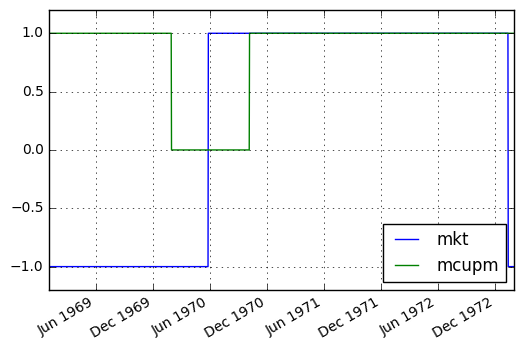

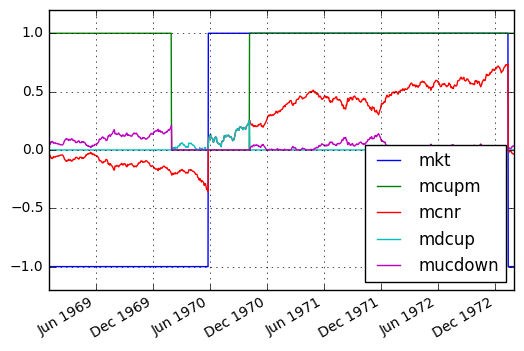

In [19]:
# Plot market cylce markers

# 

st=dt.datetime(1969,1,1)
et=dt.datetime(1973,1,31)

#st=dt.datetime(1990,1,1)
#et=dt.datetime(1994,1,31)

#st=dt.datetime(2010,1,1)
#et=dt.datetime(2010,1,31)


#st=dt.datetime(2007,1,1)
#et=dt.datetime(2008,12,31)

dfmc.loc[st:et,['mkt','mcupm']].plot(grid=True)
plt.ylim(-1.2, 1.2)

dfmc.loc[st:et,['mkt','mcupm','mcnr','mdcup','mucdown']].plot(grid=True)
plt.ylim(-1.2, 1.2)

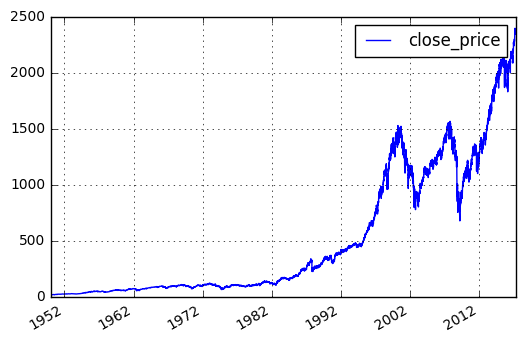

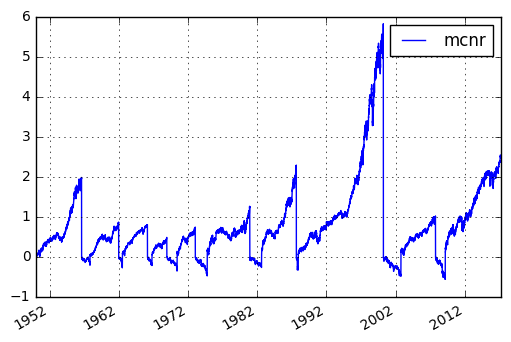

In [22]:
# Plot S&P

st=dataStartDate
et=today
#st=dt.datetime(1990,1,1)
#et=dt.datetime(2017,3,28)

dfsp.loc[st:et,['close_price']].plot(grid=True)
plt.ylim(0,2500)

dfmc.loc[st:et,['mcnr']].plot(grid=True)

In [817]:
# ML Feature Data Frame

%run algosciquant
print(ticker)
f2p=[2,5,10,20,30,60,90,120]
if ticker == '^GSPC' or ticker == 'SPX':
    mlFeatures=['sp_close_pricer','sp_volumer']
    print('\nmlFeatures')
    print(mlFeatures)
    print('\ndfsp.columns')
    print(dfsp.columns)
    dfML=mlHistoryFeatures(dfsp,dfsp,mlFeatures,f2p)
    # S&P High and Low Relative to Open
    dfML['high_price_ropen']=dfsp['high_price']/dfsp['open_price']-1
    dfML['low_price_ropen']=dfsp['low_price']/dfsp['open_price']-1
    
else:   
    mlFeatures=['adj_close_pricer','adj_volume','pricetoearnings','sp_close_pricer']
    print('\nmlFeatures')
    print(mlFeatures)
    print('\ndfsp.columns')
    print(dfsp.columns)
    dfML=mlHistoryFeatures(dfs,dfsp,mlFeatures,f2p)
    

# Market Cycle Features
#   market cycle featurs
if truth_method == 'mc':
    print("\ndfmc columns")
    print(dfmc.columns)
    print("\nMarket Cycle Features")
    mcFeatures = ['mucdown','mdcup','mcupm','dfhlm','newmhlm']
    print(mcFeatures)
    dfML=pd.concat([dfML,dfmc[mcFeatures]],axis=1,join='inner')

print("\nML features")
print(dfML.columns)

print('\nML Features (tail(3))')
print(dfML.tail(3))



^GSPC

mlFeatures
['sp_close_pricer', 'sp_volumer']

dfsp.columns
Index(['close_price', 'high_price', 'low_price', 'open_price', 'volume'], dtype='object')

dfmc columns
Index(['close_price', 'mkt', 'mchlm', 'newmhlm', 'sdm', 'mcupm', 'mcnr',
       'mucdown', 'mdcup', 'muchp', 'mdclp', 'dfhlm'],
      dtype='object')

Market Cycle Features
['mucdown', 'mdcup', 'mcupm', 'dfhlm', 'newmhlm']

ML features
Index(['sp_close_pricer', 'sp_volumer', 'sp_close_pricer_h1',
       'sp_close_pricer_h2', 'sp_close_pricer_ma5', 'sp_close_pricer_ma10',
       'sp_close_pricer_ma20', 'sp_close_pricer_ma30', 'sp_close_pricer_ma60',
       'sp_close_pricer_ma90', 'sp_close_pricer_ma120', 'sp_volumer_h1',
       'sp_volumer_h2', 'sp_volumer_ma5', 'sp_volumer_ma10', 'sp_volumer_ma20',
       'sp_volumer_ma30', 'sp_volumer_ma60', 'sp_volumer_ma90',
       'sp_volumer_ma120', 'high_price_ropen', 'low_price_ropen', 'mucdown',
       'mdcup', 'mcupm', 'dfhlm', 'newmhlm'],
      dtype='object')

ML Features (t

In [818]:
# Truth Variable (tnp1)
#   N Plus 1 .... predict today for N plus 1 (tomorrow)

    #tnp1=pd.DataFrame(np.sign(dfsp['close_price']).shift(-1))
    #tnp1=tnp1.rename(columns={'close_price':'t_np1'})
%run algosciquant
    
if truth_method =='mc':
    dftruth=pd.DataFrame(dfmc['mkt'])
    dftruth=dftruth.rename(columns={'mkt':'t_np1'}).shift(-1)
    dftflag=dfmc['newmhlm']
elif truth_method =='ndt':

    if ticker =='^GSPC':
        price_variable = 'close_price'
        df=dfsp
    else:
        price_variable ='adj_close_price'
        df=dfs
    print('ticker = ',ticker)
    print('price_variable = ',price_variable)       

    
    dftruth=ndTrendFill(df,price_variable,ndtrend)
    print(dftruth.columns)
    print('...')
    dftruth['t_np1'] = dftruth['t'].shift(-1)
    del dftruth['t']
   
print("\ndftruth columns")
print(dftruth.columns)
print(dftruth.tail(5))

if truth_method == 'mc':
    print('\ndftflag.columns')
    print(dftflag.tail(5))
    


dftruth columns
Index(['t_np1'], dtype='object')
            t_np1
2017-03-27    1.0
2017-03-28    1.0
2017-03-29    1.0
2017-03-30    1.0
2017-03-31    NaN

dftflag.columns
2017-03-27    1.0
2017-03-28    0.0
2017-03-29    0.0
2017-03-30    1.0
2017-03-31    0.0
Name: newmhlm, dtype: float64


In [198]:
# Null Rows
nullrows=sum([True for idx,row in dfML.iterrows() if any(row.isnull())])
nrows=len(dfML)
print("nrows = ",nrows,"null_rows = ",nullrows)

nrows =  6866 null_rows =  120


In [794]:
#  Classifier Training and Test
#   for each test date a classifier will be trained until test date - 1

%run algosciquant 

print('test start date =',test_st)

# Create training data frames ... separate into X and Y
X = dfML.loc[train_st:test_et,dfML.columns]
Y = dftruth.loc[train_st:test_et]

print("X columns")
print(X.columns)

print('Y columns')
print(Y.columns)


if truth_method=='mc':
    mc = 1
elif truth_method=='ebdt':
    mc=0
    dftflag=pd.DataFrame()

##### Decision Treee
ntraindays = 500
clf = DecisionTreeClassifier(min_samples_split=20, random_state=99,)

##### Random Forest
#ne=366
#ntraindays = 3000
#clf = RandomForestClassifier(n_estimators=ne, random_state=2)

##### K Nearest Neighbor
k=5
#clf=KNeighborsClassifier(n_neighbors=k,algorithm='auto')

#### XG Boost
#clf = XGBClassifier()

##### Support Vector Machine
#clf = svm.SVC(kernel='rbf', C=1,gamma='auto')

##### Gausian Naive-Bayes
#clf = GaussianNB()

##### Logistic Regression
#clf = LogisticRegression()

##### Run the classifier 

dfTR,clf = mClfTrainTest(X,Y,train_st,test_st,test_et,clf,ntraindays,mc=mc,dftflag=dftflag)

#### save DataFrame

filename="model.pkl"
dfTR.to_pickle(filename) 

print(dfTR.columns)

dfTR[['train_st','train_et','t', 'p','tf','t_np1','p_np1']].tail(10)

test start date = 2000-01-01 00:00:00
X columns
Index(['sp_close_pricer', 'sp_volumer', 'sp_close_pricer_h1',
       'sp_close_pricer_h2', 'sp_close_pricer_ma5', 'sp_close_pricer_ma10',
       'sp_close_pricer_ma20', 'sp_close_pricer_ma30', 'sp_close_pricer_ma60',
       'sp_close_pricer_ma90', 'sp_close_pricer_ma120', 'sp_volumer_h1',
       'sp_volumer_h2', 'sp_volumer_ma5', 'sp_volumer_ma10', 'sp_volumer_ma20',
       'sp_volumer_ma30', 'sp_volumer_ma60', 'sp_volumer_ma90',
       'sp_volumer_ma120', 'high_price_ropen', 'low_price_ropen', 'mucdown',
       'mdcup', 'mcupm', 'dfhlm', 'newmhlm'],
      dtype='object')
Y columns
Index(['t_np1'], dtype='object')
last t_np1 =  2017-03-31 00:00:00 t_np1   NaN
Name: 2017-03-31 00:00:00, dtype: float64
2000-01-03
2001-01-02
2002-01-02
2003-01-02
2004-01-02
2005-01-03
2006-01-03
2007-01-03
2008-01-02
2009-01-02
2010-01-04
2011-01-03
2012-01-03
2013-01-02
2014-01-02
2015-01-02
2016-01-04
2017-01-03
Training month 2017-03-31 train_st =  1990-0

,train_st,train_et,t,p,tf,t_np1,p_np1
2017-03-20,2015-11-06,2017-03-06,-1.0,-1.0,0.0,-1.0,-1.0
2017-03-21,2015-11-07,2017-03-17,-1.0,-1.0,1.0,-1.0,-1.0
2017-03-22,2015-11-08,2017-03-17,-1.0,-1.0,0.0,-1.0,-1.0
2017-03-23,2015-11-09,2017-03-17,-1.0,-1.0,0.0,-1.0,-1.0
2017-03-24,2015-11-10,2017-03-22,-1.0,-1.0,1.0,-1.0,-1.0
2017-03-27,2015-11-13,2017-03-23,-1.0,-1.0,1.0,1.0,-1.0
2017-03-28,2015-11-14,2017-03-23,1.0,-1.0,0.0,1.0,1.0
2017-03-29,2015-11-15,2017-03-23,1.0,1.0,0.0,1.0,1.0
2017-03-30,2015-11-16,2017-03-28,1.0,1.0,1.0,1.0,-1.0
2017-03-31,2015-11-17,2017-03-28,1.0,-1.0,0.0,NaN,-1.0


In [795]:
%run algosciquant
clfMktConfusionMatrix(dfTR,"t",'p')

total = 4339 
  pos (up) =  1812 
  neg (dwn) 2526
errors = 1929 correct =  2410


(4339,
 1929,
 2410,
 0.4445724821387416,
 962,
 965,
 849,
 1561,
 0.5309050772626932,
 0.3820269200316706,
 0.4685430463576159,
 0.6179730799683294,
               Actual Totals Predicted MktDwn Predicted MktUp
 actual MktDwn    pos:MktDwn               tp              fn
 actual MktUp      neg:MktUp               fp              tn,
                Actual Totals  Predicted MktDwn  Predicted MktUp
 actual MktDwn           1812               849              962
 actual MktUp            2526               965             1561,
                Actual Totals  Predicted MktDwn  Predicted MktUp
 actual MktDwn           1812          0.468543         0.530905
 actual MktUp            2526          0.382027         0.617973)

In [46]:
# write to file
filename="dfmc_2025.csv"
dfmc_2025.to_csv(filename)

In [47]:
#read from file
dfmc = pd.read_csv(filename,index_col=0,parse_dates=True)

In [42]:
# Strategy Trade CLF
%run algosciquant

pvariable='mcupm'   #, p, ps, mcupm
print('start date =',test_st)
print('end date =',test_et)

start_strategy_trade=test_st
startyr=start_strategy_trade.year
today = dt.date.today()
end_strategy_trade=dt.datetime(today.year,today.month,today.day)
endyr=today.year
startyr=start_strategy_trade.year
yday = datetime.today().timetuple().tm_yday


print(ticker)
if ticker == '^GSPC' or ticker == 'SPX':
    price_variable='close_price'  # Price Intrinio
else:
    price_variable='adj_close_price'

print(price_variable) 

if pvariable == 'mcupm':
    df1=dfmc.loc[start_strategy_trade:end_strategy_trade,['mcupm','sdm']]
else:
    df1=dfTR.loc[start_strategy_trade:end_strategy_trade,[price_variable+'r','t','p','t_np1','p_np1']]

if price_variable in dfsp.columns:
    df2=dfsp.loc[start_strategy_trade:end_strategy_trade,[price_variable]] 
elif price_variable in dfs.columns:
    df2=dfs.loc[start_strategy_trade:end_strategy_trade,[price_variable]] 

dft=pd.concat([df1, df2], axis=1,join='inner')
dft = tradeReturns(dft,price_variable)
dft = strategyTrade(dft,price_variable,price_variable+'_R',pvariable)

if pvariable =='mcupm':
    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','sdm',pvariable]].tail(5))
elif price_variable in dfsp.columns:
    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','t',pvariable,'t_np1','p_np1']].tail(5))
elif price_variable in dfs.columns:
    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','t',pvariable,'t_np1','p_np1']].tail(5))

start date = 1950-01-01 00:00:00
end date = 2017-04-05 00:00:00
^GSPC
close_price
            close_price  close_price_R  close_price_SP  sdm  mcupm
2017-03-30  2368.060059       0.002935    12485.779866  0.0    1.0
2017-03-31  2362.719971      -0.002255    12457.623839  0.0    1.0
2017-04-03  2358.840088      -0.001642    12437.166856  0.0    1.0
2017-04-04  2360.159912       0.000560    12444.125730  0.0    1.0
2017-04-05  2354.230000      -0.002513    12412.859810  0.0    1.0


In [43]:
# BackTest
%run algosciquant

(dftsummary,dfreturns)=backTest(dft,price_variable,start_strategy_trade,end_strategy_trade)

print(dftsummary)
print("")
print(dfreturns[[ 'nyear',  'Rc','Ra','Rc_strat','Ra_strat']])

     start_date  start_close_price   end_date  end_close_price  \
1950 1950-01-03          16.660000 1951-01-02        20.770000   
1951 1951-01-02          20.770000 1951-12-31        23.770000   
1952 1952-01-02          23.799999 1952-12-31        26.570000   
1953 1953-01-02          26.540001 1953-12-31        24.809999   
1954 1954-01-04          24.950001 1954-12-31        35.980000   
1955 1955-01-03          36.750000 1956-01-03        45.160000   
1956 1956-01-03          45.160000 1956-12-31        46.669998   
1957 1957-01-02          46.200001 1957-12-31        39.990002   
1958 1958-01-02          40.330002 1958-12-31        55.209999   
1959 1959-01-02          55.439999 1959-12-31        59.889999   
1960 1960-01-04          59.910000 1961-01-03        57.570000   
1961 1961-01-03          57.570000 1962-01-02        70.959999   
1962 1962-01-02          70.959999 1962-12-31        63.099998   
1963 1963-01-02          62.689999 1963-12-31        75.019997   
1964 1964-

In [38]:
# mcdp=20, mcup=25
dft_2025=dft
dfts_2025=dftsummary
dftr_2025=dfreturns

In [44]:
# mcdp=10, mcup=10
dft_1010=dft
dfts_1010=dftsummary
dftr_1010=dfreturns

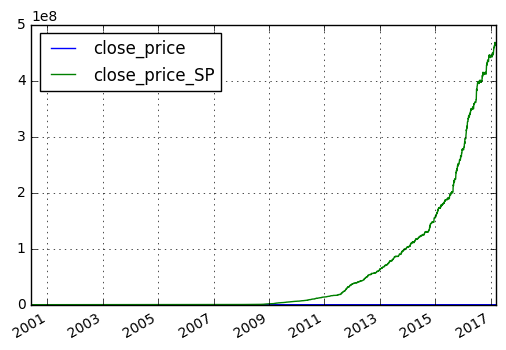

In [800]:
st = test_st
et = test_et

#st = dt.datetime(1992,1,1)
#et = dt.datetime(1994,12,31)

st = dt.datetime(2000,6,1)
et = dt.datetime(2017,3,17)

#st = dt.datetime(2016,1,1)
#et = dt.datetime(2016,12,31)

#st = dt.datetime(2008,11,1)
#et = dt.datetime(2009,7,1)

#st = dt.datetime(2009,1,1)
#et = dt.datetime(2009,12,31)

#st = dt.datetime(2017,1,1)
#et = dt.datetime(2017,3,8)

#st = dt.datetime(2009,1,1)
#et = dt.datetime(2009,4,30)


#st = dt.datetime(2009,1,1)
#et = dt.datetime(2010,1,1)

#st = dt.datetime(2007,10,1)
#et = dt.datetime(2009,12,31)

#st = dt.datetime(2008,7,1)
#et = dt.datetime(2009,4,30)

#st = dt.datetime(2008,7,1)
#et = dt.datetime(2008,10,15)

dft.loc[st:et,[price_variable,price_variable+'_SP']].plot(grid=True)


In [656]:
#st = dt.datetime(2008,9,16)
#et = dt.datetime(2008,10,14)

#st = dt.datetime(2016,7,1)
#et = dt.datetime(2016,8,1)

st = dt.datetime(2017,1,1)
et = dt.datetime(2017,1,10)

dft.loc[st:et,[price_variable,price_variable+'_R','t','p','p_np1',price_variable+'_SP']]

,close_price,close_price_R,t,p,p_np1,close_price_SP
2017-01-03,2257.830078,0.008487,1.0,-1.0,1.0,2717.519050
2017-01-04,2270.750000,0.005722,1.0,1.0,1.0,2733.069438
2017-01-05,2269.000000,-0.000771,1.0,1.0,1.0,2730.963142
2017-01-06,2276.979980,0.003517,1.0,1.0,-1.0,2740.567828
2017-01-09,2268.899902,-0.003549,1.0,-1.0,1.0,2740.567828
2017-01-10,2268.899902,0.000000,1.0,1.0,1.0,2740.567828


In [398]:
# http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html


dotf = "dt.dot"
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(dotf, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        

# the following command will export "dt.dot" file
visualize_tree(clf, X.columns)

# run the following command in the directory contaning "dt.dot" file
# > dot -Tpng dt.dot -o dt.png
# > open dt.png

## References

- Find stocks, [Kiplinger 8 Stocks](http://www.kiplinger.com/slideshow/investing/T052-S003-8-stocks-to-buy-now-for-2017/index.html)

- Kiplingers, "10 Great Stocks for the Next 10 Years", December 2016,   PNRA, ADBE, DHR, FBHS, IDXX, LGF

- Kiplingers, "8 Stocks to buy for now", Jan 2017, GOOG, CMD, AAPL, MEDP

- Kiplingers, "My Top Stock Picks for 2017," Jan 2017, AMZN, CVU, SBUX, CRM

- Other stocks, BRK.B, ^GSPC, KO

- Stanford ML CS229 Trend Stock Prediction,  [Stanford CS229 ML Stock Prediction](http://cs229.stanford.edu/proj2013/DaiZhang-MachineLearningInStockPriceTrendForecsting.pdf) ... **ML Features** PE ratio, PX volume, PX ebitda, current enterprise value, 2-day net price change, 10-day volatility, 50-day moving average, 10-day moving average, quick ratio, alpha overridable, alpha for beta pm, beta raw overridable, risk premium, IS EPS, and corresponding S&P 500 index
- CS229 Stock Prediction Feature Selection, ...  http://cs229.stanford.edu/proj2014/Xinjie%20Di,%20Stock%20Trend%20Prediction%20with%20Technical%20Indicators%20using%20SVM.pdf  ... 

- Stanford ML CS229 Text/Article Stock Prediction, [CS229 Bryce Taylor](http://cs229.stanford.edu/proj2013/Taylor-Applying%20Machine%20Learning%20to%20Stock%20Market%20Trading.pdf)
    
- Stock correlations, [Asset Correlations](https://www.portfoliovisualizer.com/asset-correlations)
    
- Example noteboek, [Python Clustering](http://brandonrose.org/clustering)

- Where to get financial data, Quroa - Intrinio, <https://www.quora.com/What-are-some-cheaper-alternatives-to-Bloomberg-data-terminal>

- Intrino, <https://intrinio.com> ... <http://blog.intrinio.com/intrinio-financial-data-in-r-and-rstudio/>  ... API  <http://blog.intrinio.com/stock-api-developers/> ...  <http://docs.intrinio.com>  ... Python Github https://github.com/nhedlund/intrinio .... http://docs.intrinio.com/tags/intrinio-public#data-point .... Converasation with Andrew Carpenter, Intrinio.com ... What I used R for, which I bet you can do better in Python, is to pull in historical prices and then a vector of historical explainatory variables on the same time period. I automated it, and filled forward the quarterly data to match the daily data. Which is the standard in the industry, I learn from my professors. So that gives you a nice clean data frame with as many explainatory variables as you want- valuation metrics, earnings, economic indicators like SPY and VIX. acarpenter@intrinio.com 727-331-3416. ... from the API page  <http://blog.intrinio.com/stock-api-developers/>  good info plus make sure to watch the video. Entire price history using "price" endpoint "https://inntrinio.com/prices?ticker=AAPL" includes 13 data points open, close, adj_high, ... volume  ... use datapoint function to pull in specific data points "https://inntrinio.com/datapoint?ticker=AAPL&item=close_price" ... use the "historical_data" endpoint to pull in time-series "https://inntrinio.com/historical_data?ticker=AAPL&item=pricetoearnings&start_date=2014-01-01&end_date_2015-01-01" ... you can also add in a frequency as "&frequency=yearly"   (yearly, quarterly, monthly, weekly, daily) ... or just the start_date ... **Historical Data Features**  <http://docs.intrinio.com/tags/intrinio-public#historical-data> ... **Modeling financial data in R** ... http://blog.intrinio.com/modeling-financial-data-in-r-with-intrinio/